#Loading the data

##Import libraries and modules




In [2]:
import numpy as np
import os
import shutil
import glob
import matplotlib.pyplot as plt
from skimage import color, exposure, transform, io
import h5py as h5py
import random



##Load the data from kaggle

The two next cells of code have to be run one time

In [17]:
# Install the Kaggle
!pip install kaggle


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
# Define paths
OBJECT_CATEGORIES_PATH = '256_ObjectCategories'
SELECTED_IMAGES_PATH = 'selected_images'

# List all image paths
image_paths = []
for root, dirs, files in os.walk(OBJECT_CATEGORIES_PATH):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):  # Filter out non-image files
            image_paths.append(os.path.join(root, file))

# Shuffle the list of image paths
random.shuffle(image_paths)

# Select the first 16,000 paths
selected_image_paths = image_paths[:16000]

# Create a directory to store the selected images
os.makedirs(SELECTED_IMAGES_PATH, exist_ok=True)

# Copy the selected images to the new directory
for image_path in selected_image_paths:
    image_name = os.path.basename(image_path)
    destination_path = os.path.join(SELECTED_IMAGES_PATH, image_name)
    shutil.copy(image_path, destination_path)

**Variables**

In [3]:
NUM_CLASSES = 44
IMG_SIZE = 48
BATCH_SIZE = 32
EPOCHS = 30

##Reorganize the data

we are addressing the task of organizing image data within a directory structure. Initially, we define paths for accessing the dataset, specifically the 'gtsrb_dataset', which contains training and testing sets. The code then proceeds to consolidate all images scattered within subfolders of the training set ('Train') into a single folder for ease of access and standardization. This consolidation ensures uniformity in data organization, simplifying subsequent data processing tasks. Finally, the code reports the number of images in both the training and testing sets before and after the consolidation process, providing insights into the dataset's composition

In [4]:
# Define the paths
DATASET_PATH = 'gtsrb-german-traffic-sign'
TRAINING_PATH = os.path.join(DATASET_PATH, 'Train')
TEST_PATH = os.path.join(DATASET_PATH, 'Test')


# Get the list of image files
train_image_files = os.listdir(TRAINING_PATH)
test_image_files = os.listdir(TEST_PATH)


# Function to move all images from subfolders into the training folder
def move_images_to_training_folder(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            source_path = os.path.join(root, file)
            destination_path = os.path.join(TRAINING_PATH, file)
            shutil.move(source_path, destination_path)

# Move all images from subfolders within the training path to the training folder
move_images_to_training_folder(TRAINING_PATH)

# Print the number of images in the training folder after moving
train_image_files = os.listdir(TRAINING_PATH)

# Print the number of images in each set
print("Number of testing images:", len(test_image_files))

print("Number of training images after moving:", len(train_image_files))


Number of testing images: 12631
Number of training images after moving: 39252


##Visualisation

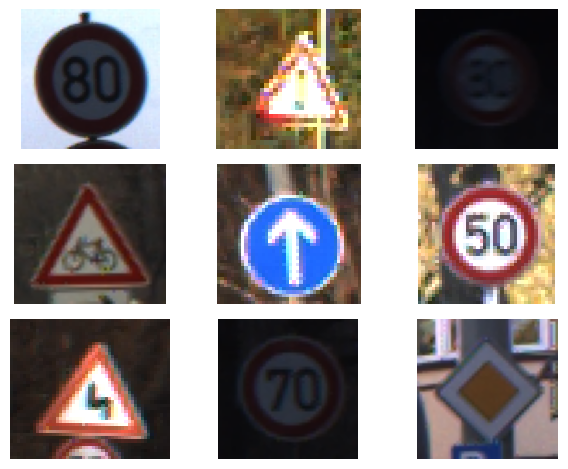

In [5]:
# Filter out non-image files
train_image_files = [file for file in os.listdir(TRAINING_PATH) if file.endswith(('.jpg', '.jpeg', '.png'))]

# Shuffle the list of image files
np.random.shuffle(train_image_files)

# Display the first 9 images
for i in range(9):
    image_path = os.path.join(TRAINING_PATH, train_image_files[i])
    image = io.imread(image_path)
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

#Pre-Processing

To prepare our images for further analysis, we will conduct preprocessing for two primary purposes:

>Normalization of Intensity: Our aim is to ensure consistent intensity levels across all images. This involves addressing issues such as overexposure or underexposure by applying histogram equalization. By doing so, we can enhance the overall exposure quality of the images, creating a more balanced and visually appealing dataset.

> Standardizing Image Size: Another key aspect of preprocessing involves resizing all images to a uniform size. This standardization ensures that all images are in the same dimensions, facilitating easier comparison and analysis across the dataset. By resizing the images uniformly, we can maintain consistency and optimize them for subsequent processing tasks effectively.

In [9]:
def preprocess_images(img):
    # Convert grayscale images to RGB
    if img.ndim == 2:
        img = color.gray2rgb(img)
    # Convert image to HSV format
    hsv = color.rgb2hsv(img)
    # Perform histogram equalization on the V channel
    hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
    img = color.hsv2rgb(hsv)

    # Check if the image dimensions are valid
    if img.shape[0] == 0 or img.shape[1] == 0:
        raise ValueError("Invalid image dimensions after histogram equalization")

    # resizing image to fixed dimension
    min_side = min(img.shape[:-1])
    center = img.shape[0] // 2, img.shape[1] // 2
    img = img[center[0] - min_side // 2: center[0] + min_side // 2,
              center[1] - min_side // 2: center[1] + min_side // 2,
              :]

    # Check if the image dimensions are valid after resizing
    if img.shape[0] == 0 or img.shape[1] == 0:
        raise ValueError("Invalid image dimensions after resizing")

    img = transform.resize(img, (IMG_SIZE, IMG_SIZE), mode='constant')

    return img

In [10]:
def get_class(img_path):
    filename = os.path.basename(img_path)  # Extract filename from img_path
    parts = filename.split('_')  # Split the filename by underscores
    class_label = parts[0][-2:]  # Take the last two characters of the first part
    return int(class_label)  # Convert the class label to an integer

In [11]:
def correct_all_paths(img_paths):
    new_paths = []
    for path in img_paths:
        path = path.replace('\\', '/')
        new_paths.append(path)
    return new_paths

In [12]:
# Construct the full paths of train images
img_paths = glob.glob(os.path.join(TRAINING_PATH, '*.png'))
img_paths = correct_all_paths(img_paths)

images = []
labels = []
# Define the path to the selected_images directory where you stored the 16,000 images from Caltech-256
selected_images_path = "selected_images"

# Iterate through img_paths
for img_path in img_paths:
    # Preprocess the image (assuming preprocess_images is properly defined)
    img = preprocess_images(io.imread(img_path))
    # Get the class label
    label = get_class(img_path)
    # Append the image and label to their respective lists
    images.append(img)
    labels.append(label)


In [13]:
# Define the label for "not traffic signs" class
not_traffic_signs_label = "not a traffic sign"

# Add the 16,000 images from Caltech-256 as non-traffic signs images
for img_path in os.listdir(selected_images_path):
    # Load the image
    img = io.imread(os.path.join(selected_images_path, img_path))
    # Preprocess the image
    img = preprocess_images(img)
    # Append the image and label to their respective lists
    images.append(img)
    labels.append(not_traffic_signs_label)



c:\Users\carin\Documents\Master 1\WS-Osnabruck\ANNs\Final_project\myenv\lib\site-packages\PIL\TiffImagePlugin.py:652: UserWarning: Metadata Warning, tag 33723 had too many entries: 1024, expected 1
  warnings.warn(


In [14]:
# Map class labels to integer indices
label_to_index = {label: index for index, label in enumerate(set(labels))}
# Convert class labels to integer indices
labels_as_indices = [label_to_index[label] for label in labels]
# Assuming one-hot encoding is used for labels
Y = np.eye(NUM_CLASSES, dtype='uint8')[labels_as_indices]
X = np.array(images, dtype='float32')

In [15]:
from collections import Counter
# Count the occurrences of each class label
class_counts = Counter(labels_as_indices)

# Print the class labels and their counts
for class_index, count in class_counts.items():
    # Convert integer index back to original class label
    class_label = [key for key, value in label_to_index.items() if value == class_index][0]
    print(f"Class: {class_label}, Count: {count}")

Class: 0, Count: 210
Class: 1, Count: 2220
Class: 2, Count: 2250
Class: 3, Count: 1410
Class: 4, Count: 1980
Class: 5, Count: 1860
Class: 6, Count: 420
Class: 7, Count: 1440
Class: 8, Count: 1410
Class: 9, Count: 1470
Class: 10, Count: 2010
Class: 11, Count: 1320
Class: 12, Count: 2100
Class: 13, Count: 2160
Class: 14, Count: 780
Class: 15, Count: 630
Class: 16, Count: 420
Class: 17, Count: 1110
Class: 18, Count: 1200
Class: 19, Count: 210
Class: 20, Count: 360
Class: 21, Count: 330
Class: 22, Count: 390
Class: 23, Count: 510
Class: 24, Count: 270
Class: 25, Count: 1500
Class: 26, Count: 600
Class: 27, Count: 240
Class: 28, Count: 540
Class: 29, Count: 270
Class: 30, Count: 450
Class: 31, Count: 780
Class: 32, Count: 240
Class: 33, Count: 689
Class: 34, Count: 420
Class: 35, Count: 1200
Class: 36, Count: 390
Class: 37, Count: 210
Class: 38, Count: 2070
Class: 39, Count: 300
Class: 40, Count: 360
Class: 41, Count: 240
Class: 42, Count: 240
Class: not a traffic sign, Count: 16000


**Visualisation of the images after the pre-process**

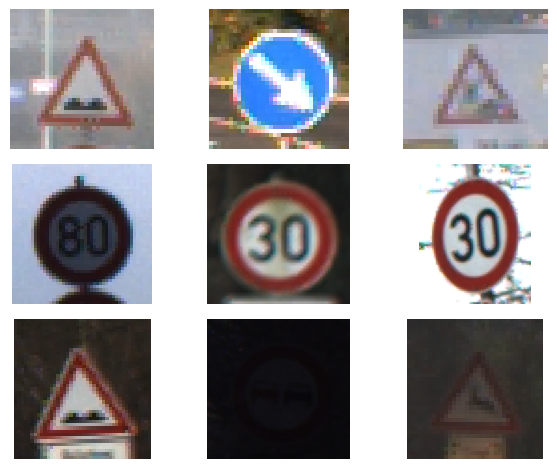

In [19]:
# Filter out non-image files
train_image_files = [file for file in os.listdir(TRAINING_PATH) if file.endswith(('.jpg', '.jpeg', '.png'))]

# Shuffle the list of image files
np.random.shuffle(train_image_files)

# Display the first 9 images
for i in range(9):
    image_path = os.path.join(TRAINING_PATH, train_image_files[i])
    image = io.imread(image_path)
    plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

#Building a convolutionnal neural network model

We will now build our sequential CNN model with following specifications:


> 6 convolutional layer followed by one hidden layer and one output layer(fully connected or dense layer).


> Dropout layers for regularization to avoid overfitting


> Relu activation function for all convolutional layers


> Softmax activation function for output layer as it is a multi-class classification problem


> Flatten layer for reshaping the output of the convolutional layer

##Import of useful libraries

To be run one time

In [20]:
!pip install scikit-learn


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers.legacy import SGD
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd

In [41]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


##Function to build the CNN

In [25]:
def build_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding ='same', input_shape = (IMG_SIZE, IMG_SIZE, 3), activation = 'relu'))
    model.add(Conv2D(32, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding ='same', activation = 'relu'))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding ='same', activation = 'relu'))
    model.add(Conv2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation = 'softmax'))
    return model

Lets us now compile our model using loss function as categorical_crossentropy

In [26]:
model = build_cnn_model()
lr = 0.01
sgd = SGD(learning_rate = lr, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])


We will utilize key callback functionalities provided by Keras, including 'LearningRateScheduler', 'ModelCheckpoint', and 'EarlyStopping'.

The Learning Rate Scheduler dynamically adjusts the learning rate during training. Gradually reducing the learning rate over epochs can potentially enhance the model's learning capability.

Model Checkpointing facilitates the automatic saving of the model with the highest validation accuracy achieved during training. This ensures that we retain the best-performing model in case of overfitting or other issues.

Early Stopping is employed to halt the training process if the improvement in accuracy over a set number of epochs, known as 'patience', falls below a specified threshold. This helps prevent unnecessary training iterations when the model's performance plateaus.

In [27]:
def learning_rate_scheduler(epoch):
    return lr * (0.1 ** int(epoch / 10))

#Training the model

In [28]:
 model_history = model.fit(X, Y,
                          batch_size = BATCH_SIZE,
                          epochs = EPOCHS,
                          validation_split = 0.2,
                          verbose = 1,
                          callbacks = [LearningRateScheduler(learning_rate_scheduler),
                                      ModelCheckpoint('model.h5', save_best_only=True),
                                      ])

Epoch 1/30


1381/1381 [==============================] - 266s 191ms/step - loss: 1.4878 - accuracy: 0.5966 - val_loss: 0.7235 - val_accuracy: 0.8496 - lr: 0.0100
Epoch 2/30


c:\Users\carin\Documents\Master 1\WS-Osnabruck\ANNs\Final_project\myenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1381/1381 [==============================] - 236s 171ms/step - loss: 0.2432 - accuracy: 0.9281 - val_loss: 0.1030 - val_accuracy: 0.9740 - lr: 0.0100
Epoch 3/30
1381/1381 [==============================] - 226s 164ms/step - loss: 0.1503 - accuracy: 0.9551 - val_loss: 0.0746 - val_accuracy: 0.9817 - lr: 0.0100
Epoch 4/30
1381/1381 [==============================] - 227s 164ms/step - loss: 0.1108 - accuracy: 0.9663 - val_loss: 0.1018 - val_accuracy: 0.9765 - lr: 0.0100
Epoch 5/30
1381/1381 [==============================] - 222s 161ms/step - loss: 0.0833 - accuracy: 0.9744 - val_loss: 0.0665 - val_accuracy: 0.9817 - lr: 0.0100
Epoch 6/30
1381/1381 [==============================] - 227s 164ms/step - loss: 0.0757 - accuracy: 0.9767 - val_loss: 0.1615 - val_accuracy: 0.9563 - lr: 0.0100
Epoch 7/30
1381/1381 [==============================] - 225s 163ms/step - loss: 0.0617 - accuracy: 0.9807 - val_loss: 0.1341 - val_accuracy: 0.9666 - lr: 0.0100
Epoch 8/30
1381/1381 [=======================

history for Accuracy

##Plotting accuracy and loss

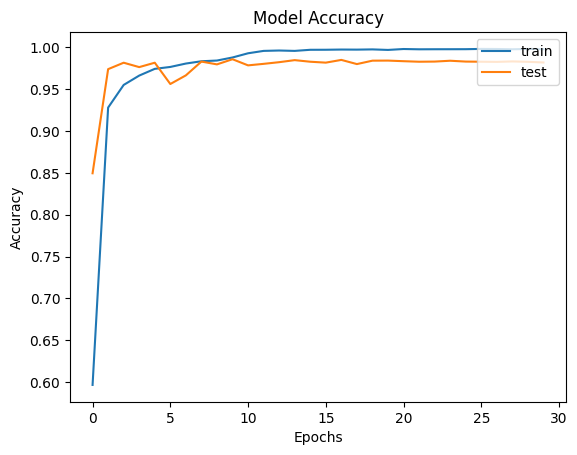

In [29]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

History for loss

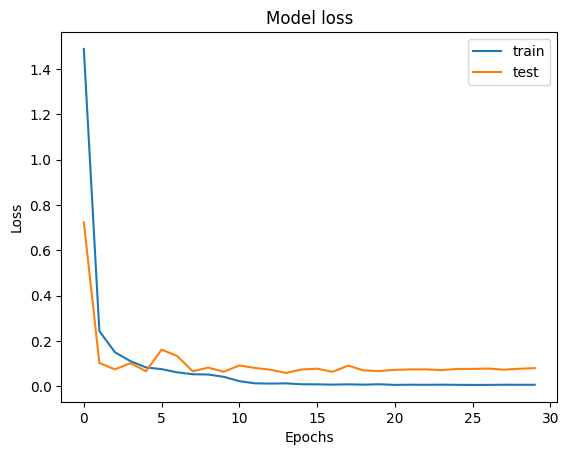

In [30]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

##Model evaluation

In [34]:
test_data = pd.read_csv('gtsrb-german-traffic-sign\Test.csv', sep =',' )

# Loading test data
X_test = []
y_test = []
for file_name, class_id in zip(list(test_data['Path']), list(test_data['ClassId'])):
    img_path = os.path.join('gtsrb-german-traffic-sign', file_name)
    X_test.append(preprocess_images(io.imread(img_path)))
    y_test.append(class_id)

X_test = np.array(X_test)
y_test = np.array(y_test)

# predict and evaluate
y_predict = model.predict(X_test)
# Convert predicted probabilities to class labels
y_predict = np.argmax(y_predict, axis=1)

accuracy = np.sum(y_predict == y_test) / np.size(y_predict)
print("Test accuracy = {}".format(accuracy))

395/395 [==============================] - 13s 31ms/step
Test accuracy = 0.9721298495645289


##Improving accuracy

The current test accuracy is satisfactory, but there's potential for further enhancement through the implementation of data augmentation techniques. Data augmentation involves expanding the training dataset by applying various transformations such as rotation, shearing, flipping, among others, to augment images.

In [35]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size =0.2, random_state = 42)

datagen = ImageDataGenerator(featurewise_center = False,
                            featurewise_std_normalization = False,
                            width_shift_range = 0.1,
                            height_shift_range = 0.1,
                            zoom_range =0.2,
                            shear_range = 0.1,
                            rotation_range = 10)
datagen.fit(X_train)

In [36]:
# Reinstialize models
model = build_cnn_model()

lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])

c:\Users\carin\Documents\Master 1\WS-Osnabruck\ANNs\Final_project\myenv\lib\site-packages\keras\src\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [37]:
model_history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size= BATCH_SIZE),
                            steps_per_epoch=X_train.shape[0] / BATCH_SIZE,
                            epochs= EPOCHS,
                            validation_data=(X_val, Y_val),
                            callbacks=[LearningRateScheduler(learning_rate_scheduler),
                                       ModelCheckpoint('model_aug.h5',save_best_only=True),
                                      ])

Epoch 1/30


C:\Users\carin\AppData\Local\Temp\ipykernel_10308\3250812649.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size= BATCH_SIZE),


1380/1380 [==============================] - 235s 169ms/step - loss: 2.1114 - accuracy: 0.4446 - val_loss: 0.8564 - val_accuracy: 0.7390 - lr: 0.0100
Epoch 2/30


c:\Users\carin\Documents\Master 1\WS-Osnabruck\ANNs\Final_project\myenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1380/1380 [==============================] - 229s 166ms/step - loss: 0.8373 - accuracy: 0.7387 - val_loss: 0.2087 - val_accuracy: 0.9350 - lr: 0.0100
Epoch 3/30
1380/1380 [==============================] - 229s 166ms/step - loss: 0.4344 - accuracy: 0.8663 - val_loss: 0.0864 - val_accuracy: 0.9758 - lr: 0.0100
Epoch 4/30
1380/1380 [==============================] - 228s 165ms/step - loss: 0.2955 - accuracy: 0.9103 - val_loss: 0.0603 - val_accuracy: 0.9832 - lr: 0.0100
Epoch 5/30
1380/1380 [==============================] - 224s 162ms/step - loss: 0.2224 - accuracy: 0.9315 - val_loss: 0.0389 - val_accuracy: 0.9885 - lr: 0.0100
Epoch 6/30
1380/1380 [==============================] - 224s 162ms/step - loss: 0.1864 - accuracy: 0.9444 - val_loss: 0.0355 - val_accuracy: 0.9893 - lr: 0.0100
Epoch 7/30
1380/1380 [==============================] - 224s 162ms/step - loss: 0.1634 - accuracy: 0.9517 - val_loss: 0.0378 - val_accuracy: 0.9888 - lr: 0.0100
Epoch 8/30
1380/1380 [=======================

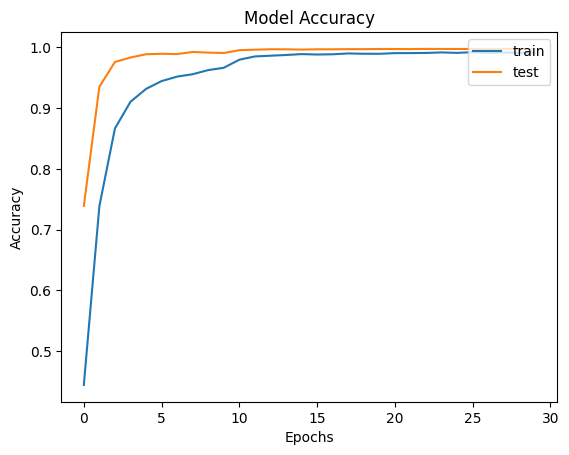

In [38]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

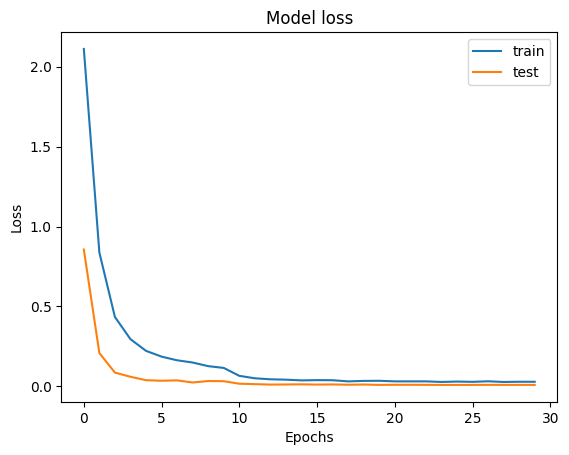

In [39]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

In [40]:
# predict again and re-evaluate
y_predict = model.predict(X_test)
# Convert predicted probabilities to class labels
y_predict = np.argmax(y_predict, axis=1)

accuracy = np.sum(y_predict == y_test) / np.size(y_predict)
print("Test accuracy = {}".format(accuracy))


395/395 [==============================] - 12s 31ms/step
Test accuracy = 0.9818685669041963


GradCam Part

In [41]:

model.save('new_traffic_signs_model.h5')

In [50]:
model.save('new_traffic_signs_model.keras')

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 23, 23, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 21, 21, 64)        36928     
                                                      

Upload many images

In [43]:
from tensorflow import keras
from IPython.display import Image, display
from PIL import Image
import matplotlib as mpl
from tensorflow.keras.models import load_model
import cv2

In [44]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [45]:
def preprocess(img):
    # Resize image to (48, 48) pixels
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Normalize pixel values to be in the range [0, 1]
    img = img.astype("float32") / 255.0
    return img

In [48]:
# Label Overview
classes = {0: 'Speed limit (20km/h)',
           1: 'Speed limit (30km/h)',
           2: 'Speed limit (50km/h)',
           3: 'Speed limit (60km/h)',
           4: 'Speed limit (70km/h)',
           5: 'Speed limit (80km/h)',
           6: 'End of speed limit (80km/h)',
           7: 'Speed limit (100km/h)',
           8: 'Speed limit (120km/h)',
           9: 'No passing',
           10: 'No passing veh over 3.5 tons',
           11: 'Right-of-way at intersection',
           12: 'Priority road',
           13: 'Yield',
           14: 'Stop',
           15: 'No vehicles',
           16: 'Veh > 3.5 tons prohibited',
           17: 'No entry',
           18: 'General caution',
           19: 'Dangerous curve left',
           20: 'Dangerous curve right',
           21: 'Double curve',
           22: 'Bumpy road',
           23: 'Slippery road',
           24: 'Road narrows on the right',
           25: 'Road work',
           26: 'Traffic signals',
           27: 'Pedestrians',
           28: 'Children crossing',
           29: 'Bicycles crossing',
           30: 'Beware of ice/snow',
           31: 'Wild animals crossing',
           32: 'End speed + passing limits',
           33: 'Turn right ahead',
           34: 'Turn left ahead',
           35: 'Ahead only',
           36: 'Go straight or right',
           37: 'Go straight or left',
           38: 'Keep right',
           39: 'Keep left',
           40: 'Roundabout mandatory',
           41: 'End of no passing',
           42: 'End no passing veh > 3.5 tons',
           43: 'Not a traffic sign'}

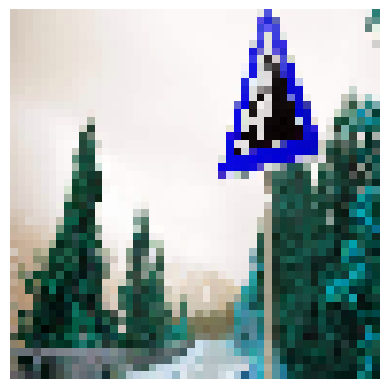

1/1 [==============================] - 0s 132ms/step
Predicted class index: 43
Predicted class label: Not a traffic sign


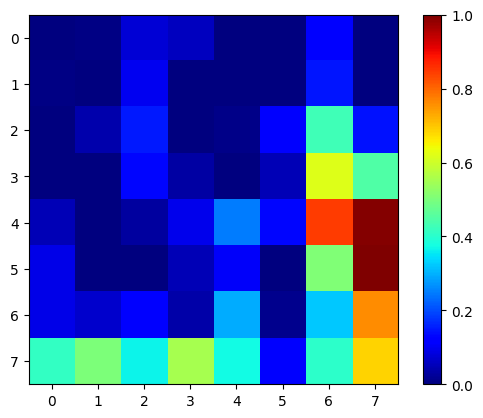

In [56]:
import cv2
last_conv_layer_name = "conv2d_11"
path_img = "uploads\german-road-signs.jpg"

# Load the model
model = load_model('new_traffic_signs_model.keras')

# Remove last layer's softmax
model.layers[-1].activation = None

# Prepare image
img_array = cv2.imread(path_img)
img_array = preprocess(img_array)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

plt.imshow(cv2.cvtColor(img_array[0], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


preds = model.predict(img_array)

# Print the predicted class index
predicted_class_index = np.argmax(preds[0])
print("Predicted class index:", predicted_class_index)

# Map the predicted class index to the class label
class_label = classes[predicted_class_index]
print("Predicted class label:", class_label)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.imshow(heatmap, cmap='jet')
plt.colorbar()
plt.show()

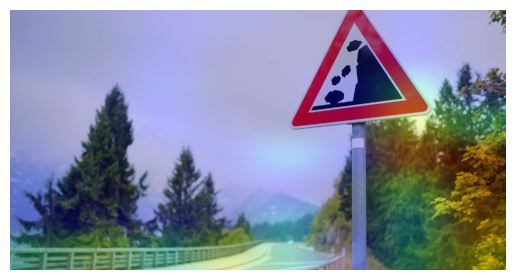

In [57]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()


save_and_display_gradcam(path_img, heatmap)